# Segmentation Client pour le Retail en Ligne

> Ce projet vise à segmenter les clients d'une entreprise de retail en ligne britannique en analysant leurs comportements d'achat entre 2010-2011 via le dataset Online Retail. L'objectif est d'optimiser les actions marketing avec des stratégies personnalisées (promotions ciblées, programmes de fidélisation, etc.).

> Pour cet exercice et pour des questions d'organisation, je mettrai les librairies nécessaires dans la même cellule. Je trouve que c'est une bonne pratique.

In [9]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.preprocessing import RobustScaler  # Ajout de cet import
from ucimlrepo import fetch_ucirepo 

> On récupère le dataset Online Retail

In [10]:
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
X = online_retail.data.features 

> On créé le fichier online_retail.csv dans le dossier data. Ce n'est pas obligatoire mais cela permet d'avoir une copie locale du dataset.

In [11]:
# Création du répertoire data s'il n'existe pas
if not os.path.exists('data'):
    os.makedirs('data')

# Export du dataset au format CSV
X.to_csv('data/online_retail.csv', index=False)
print("Le fichier a été exporté avec succès dans le dossier 'data'")

Le fichier a été exporté avec succès dans le dossier 'data'


## Phase 1 : Exploration des données

Aperçu des premières lignes:
                           Description  Quantity     InvoiceDate  UnitPrice  \
0   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55   
1                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39   
2       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75   
3  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39   
4       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39   

   CustomerID         Country  
0     17850.0  United Kingdom  
1     17850.0  United Kingdom  
2     17850.0  United Kingdom  
3     17850.0  United Kingdom  
4     17850.0  United Kingdom  

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  540455 non-null  object 
 1   Quantity     541909 non-null  

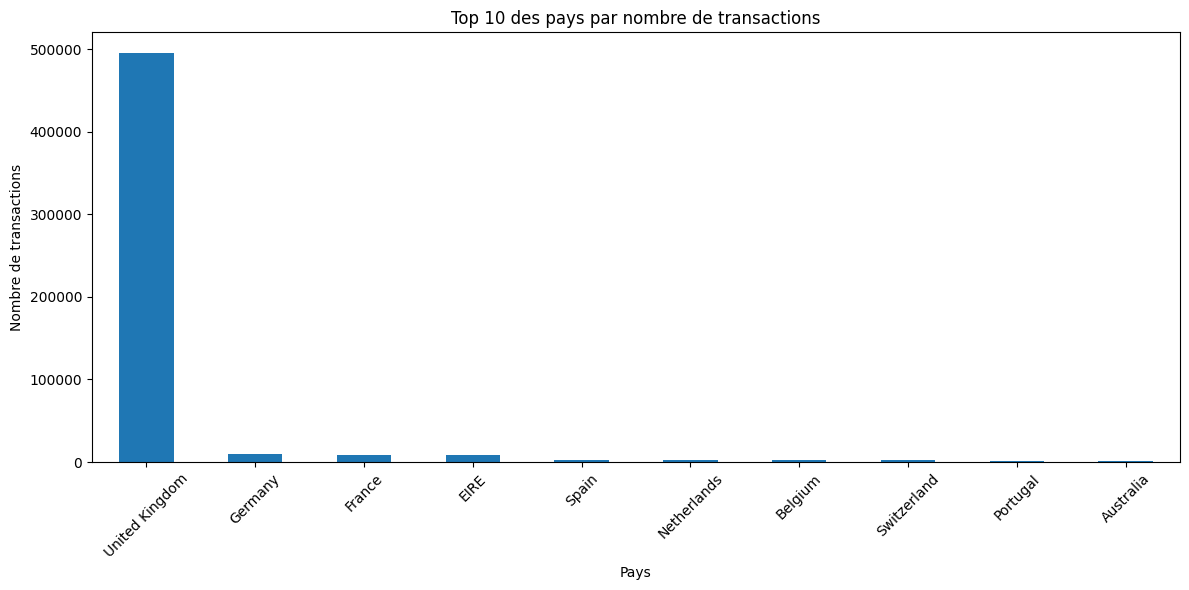

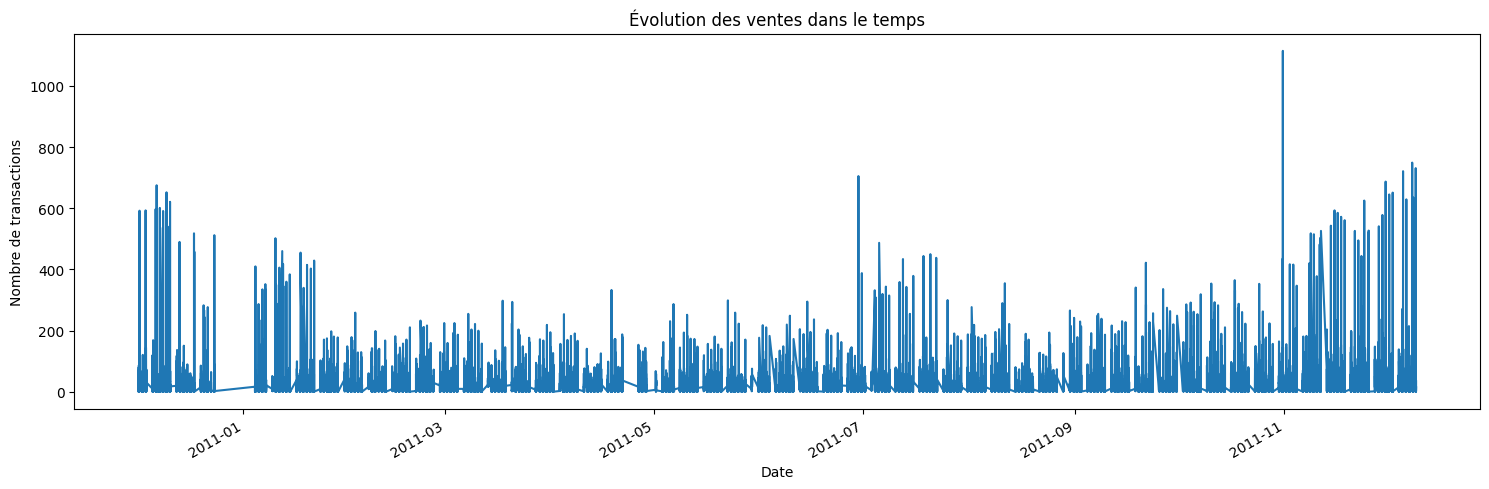

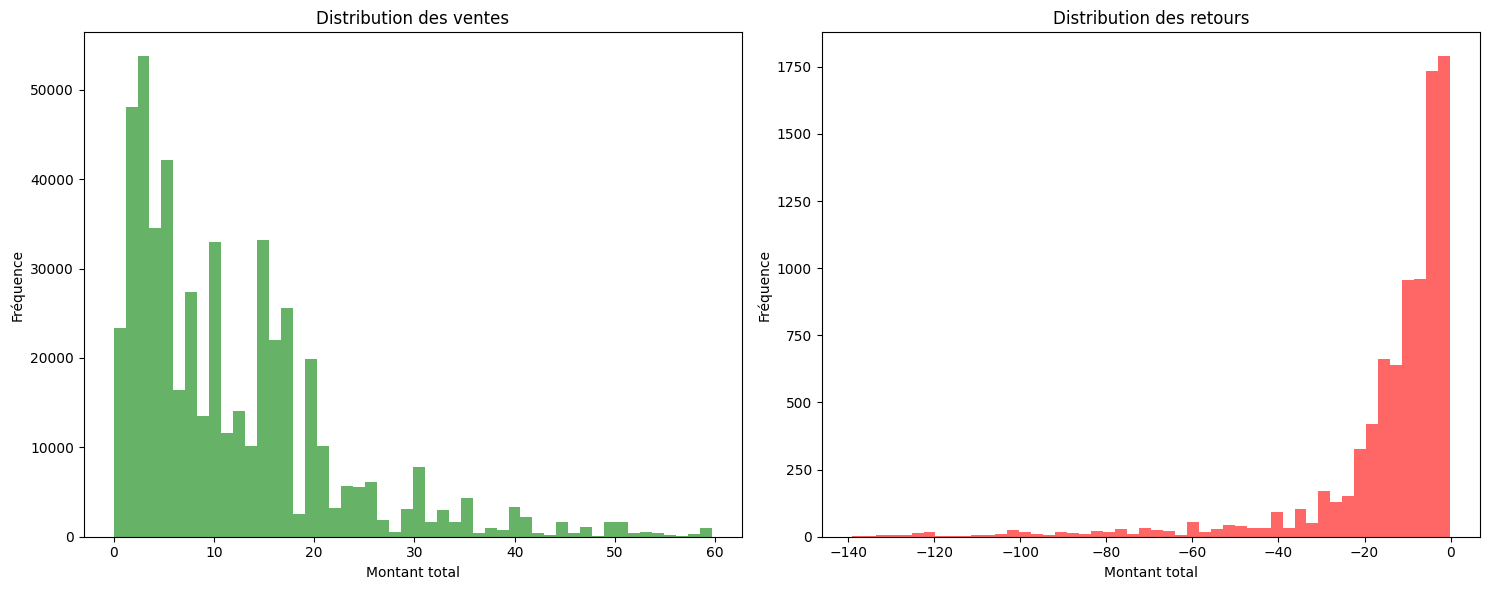

Nombre total de transactions : 541909
Nombre de ventes : 530104 (97.8%)
Nombre de retours : 9290 (1.7%)

Statistiques sur les clients:
Nombre total de clients uniques: 4372
Nombre moyen de transactions par client: 123.95


In [12]:
# Affichons les premières lignes du dataset pour comprendre sa structure
print("Aperçu des premières lignes:")
print(X.head())

# Informations générales sur le dataset
print("\nInformations sur le dataset:")
print(X.info())

# Statistiques descriptives
print("\nStatistiques descriptives:")
print(X.describe())

# Vérifions les valeurs manquantes
print("\nNombre de valeurs manquantes par colonne:")
print(X.isnull().sum())

# Analyse de la distribution des pays
print("\nDistribution des ventes par pays:")
pays_distribution = X['Country'].value_counts()
print(pays_distribution)

# Visualisation de la distribution des pays
plt.figure(figsize=(12, 6))
pays_distribution.head(10).plot(kind='bar')
plt.title('Top 10 des pays par nombre de transactions')
plt.xlabel('Pays')
plt.ylabel('Nombre de transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyse temporelle des ventes
X = X.assign(InvoiceDate=pd.to_datetime(X['InvoiceDate']))
ventes_temporelles = X.groupby('InvoiceDate').size()

plt.figure(figsize=(15, 5))
ventes_temporelles.plot()
plt.title('Évolution des ventes dans le temps')
plt.xlabel('Date')
plt.ylabel('Nombre de transactions')
plt.tight_layout()
plt.show()

# Calcul du montant total par transaction
X = X.assign(TotalAmount = X['Quantity'] * X['UnitPrice'])

# Création de deux sous-ensembles
transactions_positives = X[X['TotalAmount'] > 0]['TotalAmount']
transactions_negatives = X[X['TotalAmount'] < 0]['TotalAmount']

# Création d'un subplot avec 2 graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution des montants positifs (ventes)
ax1.hist(transactions_positives[transactions_positives < transactions_positives.quantile(0.95)], 
         bins=50, color='green', alpha=0.6)
ax1.set_title('Distribution des ventes')
ax1.set_xlabel('Montant total')
ax1.set_ylabel('Fréquence')

# Distribution des montants négatifs (retours)
ax2.hist(transactions_negatives[transactions_negatives > transactions_negatives.quantile(0.05)], 
         bins=50, color='red', alpha=0.6)
ax2.set_title('Distribution des retours')
ax2.set_xlabel('Montant total')
ax2.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Affichage des statistiques
print(f"Nombre total de transactions : {len(X)}")
print(f"Nombre de ventes : {len(transactions_positives)} ({len(transactions_positives)/len(X)*100:.1f}%)")
print(f"Nombre de retours : {len(transactions_negatives)} ({len(transactions_negatives)/len(X)*100:.1f}%)")

# Statistiques sur les clients
print("\nStatistiques sur les clients:")
print(f"Nombre total de clients uniques: {X['CustomerID'].nunique()}")
print(f"Nombre moyen de transactions par client: {len(X) / X['CustomerID'].nunique():.2f}")


### Interprétation des résultats

D'après l'analyse des données, nous pouvons observer plusieurs points importants :

### Distribution des transactions
- Le jeu de données contient un mélange de ventes (transactions positives) et de retours (transactions négatives)
- La grande majorité des transactions sont des ventes, avec une distribution asymétrique vers la droite
- Les retours représentent une plus petite proportion des transactions

### Comportement client
- La base de données contient un nombre significatif de clients uniques
- En moyenne, chaque client effectue plusieurs transactions
- Les montants des transactions sont variables mais restent généralement modérés

### Implications pour la segmentation
- La présence de retours devra être prise en compte dans l'analyse du comportement client
- La fréquence des transactions par client suggère des opportunités de segmentation basées sur les habitudes d'achat
- La distribution des montants pourrait aider à identifier différents segments de clients (petits acheteurs vs gros acheteurs)

## Phase 2 : Prétraitement des données


Vérification des valeurs manquantes:
Recency      0
Frequency    0
Monetary     0
dtype: int64

Statistiques descriptives des features RFM normalisées:
           Recency    Frequency      Monetary
count  4372.000000  4372.000000  4.372000e+03
mean      0.333707     0.509950  9.528589e-01
std       0.799726     2.312152  6.244046e+00
min      -0.388889    -0.500000 -4.942008e-01
25%      -0.261905    -0.500000 -2.691690e-01
50%       0.000000     0.000000 -4.318998e-17
75%       0.738095     0.500000  7.308310e-01
max       2.571429    61.250000  2.118633e+02


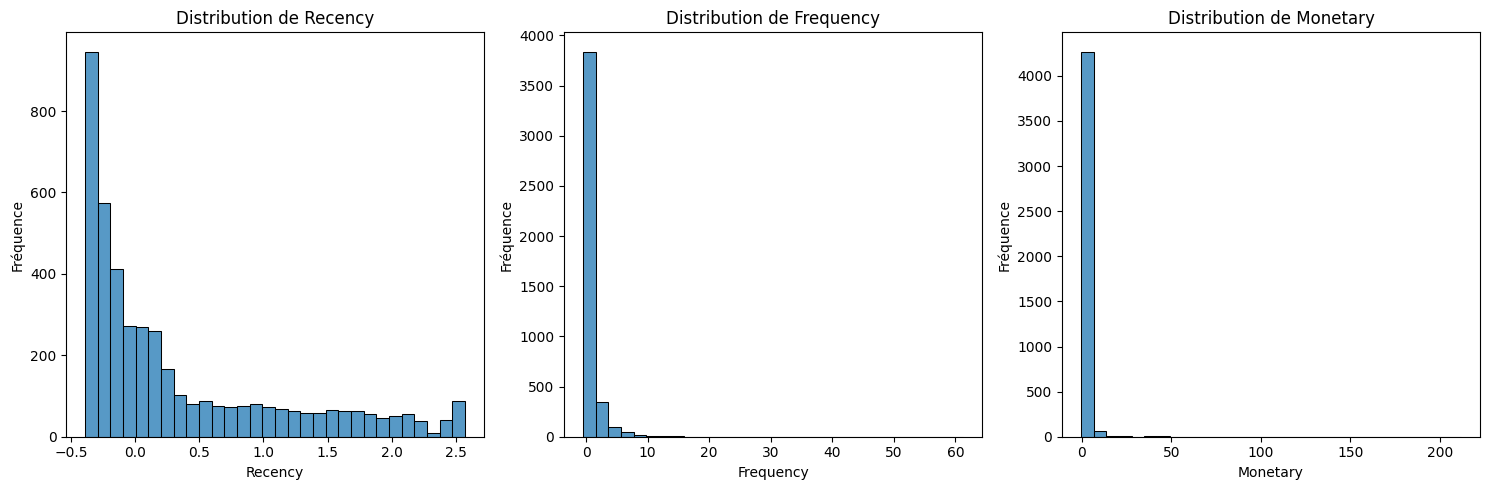

In [13]:
# Création des features RFM (Recency, Frequency, Monetary)

# Création du TotalAmount s'il n'existe pas déjà
if 'TotalAmount' not in X.columns:
    X['TotalAmount'] = X['Quantity'] * X['UnitPrice']

# Calculer les métriques RFM par client
date_max = pd.to_datetime(X['InvoiceDate']).max()

# Création du DataFrame RFM avec des agrégations séparées
rfm = pd.DataFrame()

# Calcul de Recency
rfm['Recency'] = X.groupby('CustomerID')['InvoiceDate'].apply(
    lambda x: (date_max - pd.to_datetime(x).max()).days + 1
)

# Calcul de Frequency
rfm['Frequency'] = X.groupby('CustomerID')['InvoiceDate'].nunique()

# Calcul de Monetary
rfm['Monetary'] = X.groupby('CustomerID')['TotalAmount'].sum().abs()

# Normalisation des données avec RobustScaler pour gérer les outliers
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])


# Vérification des données manquantes
print("\nVérification des valeurs manquantes:")
print(rfm_scaled.isnull().sum())

# Affichage des statistiques descriptives
print("\nStatistiques descriptives des features RFM normalisées:")
print(rfm_scaled.describe())

# Visualisation de la distribution des features
plt.figure(figsize=(15, 5))

for i, colonne in enumerate(rfm_scaled.columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=rfm_scaled[colonne], bins=30)
    plt.title(f'Distribution de {colonne}')
    plt.xlabel(colonne)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

> Analyse RFM (Recency, Frequency, Monetary):
> - Recency: Nombre de jours depuis le dernier achat du client
> - Frequency: Nombre total d'achats effectués par le client
> - Monetary: Montant total dépensé par le client

> Les graphiques ci-dessus montrent la distribution des trois variables RFM après normalisation :
>
> - Recency : La distribution est légèrement asymétrique vers la droite, indiquant que la plupart des clients ont fait des achats récemment, avec quelques clients ayant des périodes d'inactivité plus longues.
>
> - Frequency : La distribution est fortement asymétrique vers la droite, ce qui signifie qu'une grande partie des clients font peu d'achats, tandis qu'un petit nombre de clients très fidèles font beaucoup d'achats.
>
> - Monetary : Similaire à la fréquence, la distribution est asymétrique vers la droite, montrant que la majorité des clients dépensent des montants modérés, avec quelques clients qui dépensent significativement plus.
>
> La normalisation avec RobustScaler a permis de réduire l'impact des valeurs extrêmes tout en préservant la forme générale des distributions.

## Phase 4 : Réduction des dimensions

> D'après l'analyse du dataset et des visualisations RFM précédentes, nous avons 3 dimensions (Recency, Frequency, Monetary) qui sont déjà assez concises. Une réduction de dimensions n'est pas strictement nécessaire, mais nous pouvons utiliser l'ACP (Analyse en Composantes Principales) pour visualiser les relations entre ces variables.

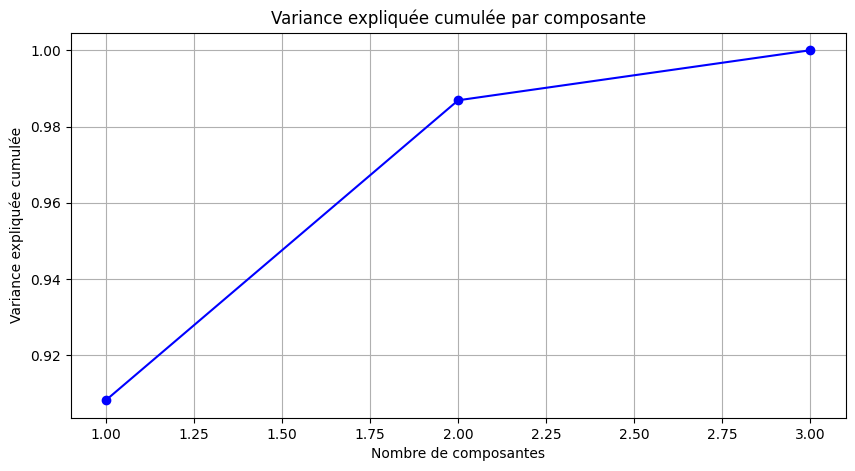

Variance expliquée par composante :
Composante 1: 0.908 (90.8%)
Composante 2: 0.079 (7.9%)
Composante 3: 0.013 (1.3%)


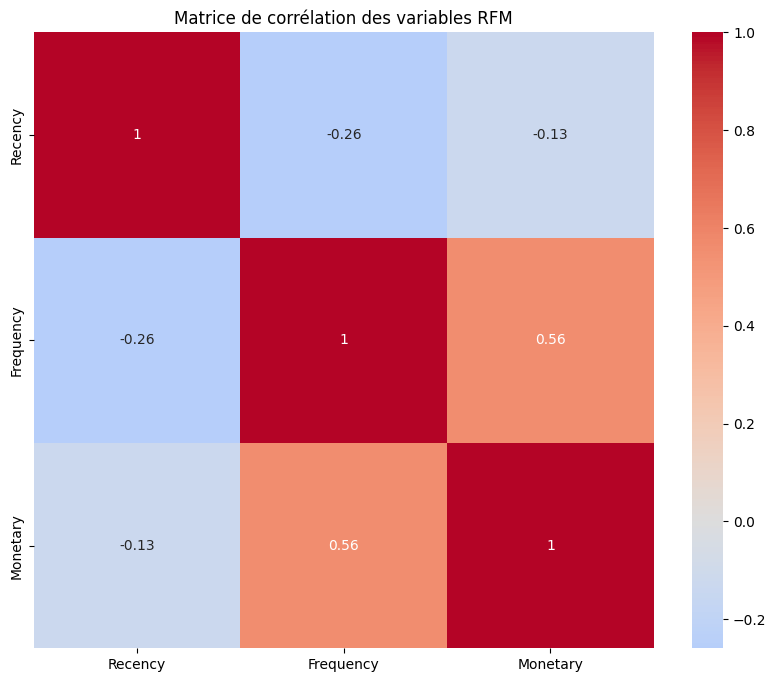

In [14]:
# Import nécessaire
from sklearn.decomposition import PCA

# Application de PCA
pca = PCA()
rfm_pca = pca.fit_transform(rfm_scaled)

# Analyse de la variance expliquée
variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par composante')
plt.grid(True)
plt.show()

# Affichage des résultats
print("Variance expliquée par composante :")
for i, var in enumerate(variance_ratio):
    print(f"Composante {i+1}: {var:.3f} ({var*100:.1f}%)")

# Visualisation des corrélations entre variables originales
plt.figure(figsize=(10, 8))
sns.heatmap(rfm_scaled.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des variables RFM')
plt.show()

### Interprétation de l'ACP :
 
> D'après les résultats de l'ACP, nous pouvons observer que :
>
> 1. La première composante explique 90.8% de la variance totale
> 2. La deuxième composante ajoute 7.9% supplémentaires
> 3. La troisième composante complète avec les 1.3% restants
>
> La matrice de corrélation montre que :
> - Frequency et Monetary sont positivement corrélées
> - Recency est négativement corrélée avec Frequency et Monetary
>
> Conclusion :
> Étant donné que :
> - Nous n'avons que 3 dimensions initiales
> - Chaque composante apporte une contribution significative à l'explication de la variance
> - Nous n'avons que 3 dimensions initiales
> - Chaque composante apporte une contribution significative à l'explication de la variance
> - Les variables ont des corrélations intéressantes mais modérées
>
> Il n'est pas nécessaire de réduire les dimensions pour notre analyse de segmentation.
> Nous conserverons les 3 variables RFM originales qui sont déjà bien interprétables.

## Phase 5 : Application des techniques d’apprentissage non supervisé

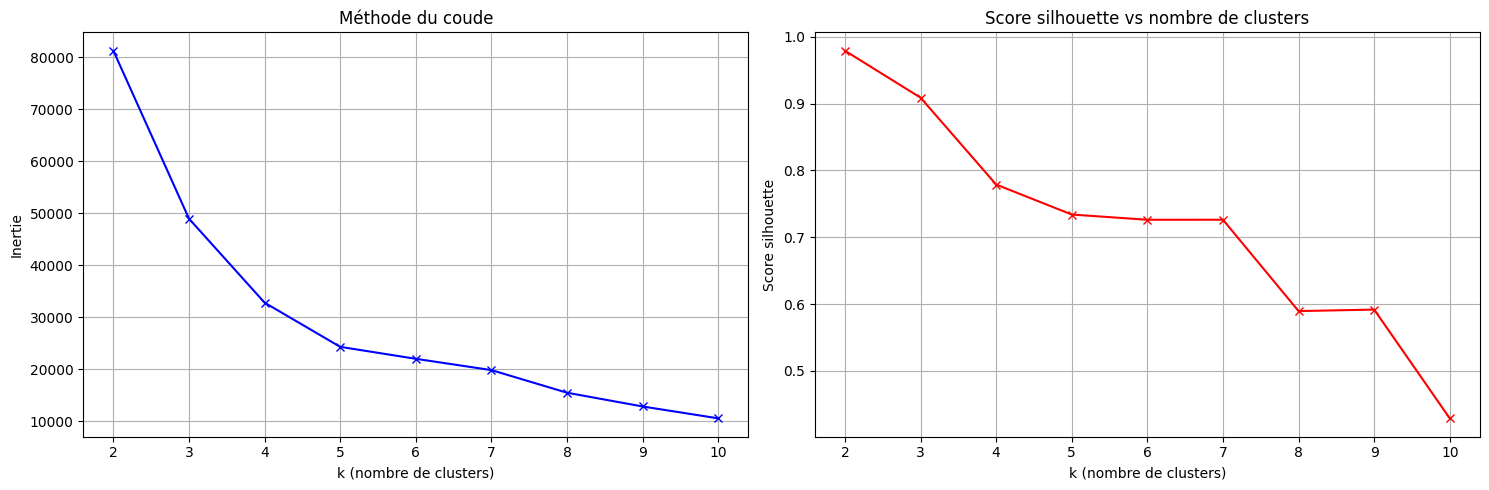

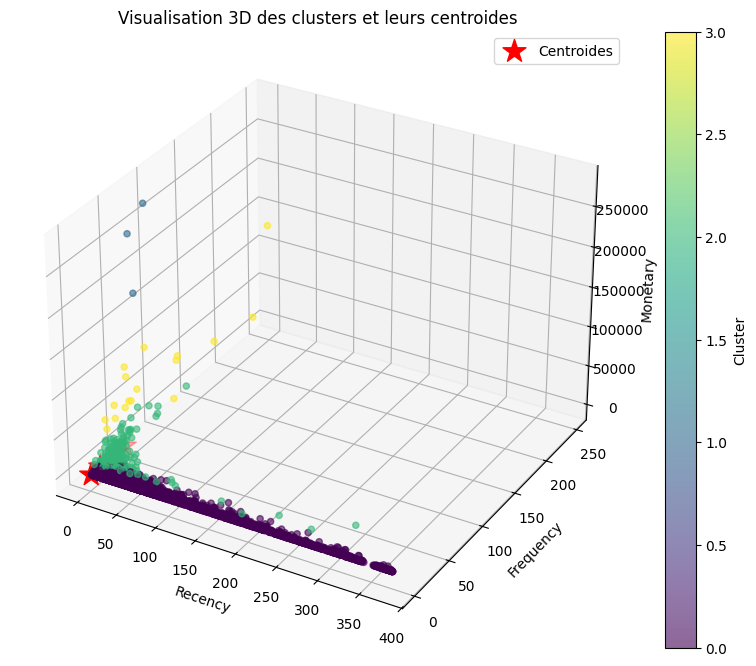


Caractéristiques moyennes par cluster :
         Recency  Frequency   Monetary
Cluster                               
0          96.15       3.71    1039.10
1           3.67      63.00  241136.56
2          17.32      24.86   10503.38
3           7.12      81.29   67103.86

Position des centroides (dans l'espace original) :
           Recency  Frequency  Monetary
Cluster 0     0.63       0.92      2.80
Cluster 1     0.04      35.19   1141.88
Cluster 2     0.13      13.15     47.70
Cluster 3     0.06      45.77    316.23


In [15]:
# Importation des bibliothèques nécessaires pour le clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Détermination du nombre optimal de clusters avec la méthode du coude
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    # Entraînement du modèle KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    
    # Calcul de l'inertie
    inertias.append(kmeans.inertia_)
    
    # Calcul du score silhouette
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Visualisation de la méthode du coude
plt.figure(figsize=(15, 5))

# Premier subplot pour l'inertie
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k (nombre de clusters)')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.grid(True)

# Deuxième subplot pour le score silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k (nombre de clusters)')
plt.ylabel('Score silhouette')
plt.title('Score silhouette vs nombre de clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# Application du KMeans avec le nombre optimal de clusters
n_clusters = 4  # À ajuster selon les résultats de la méthode du coude
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters = kmeans_final.fit_predict(rfm_scaled)

# Ajout des clusters au DataFrame original
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)

# Visualisation des clusters en 3D avec les centroides
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Affichage des points
scatter = ax.scatter(rfm['Recency'], 
                    rfm['Frequency'], 
                    rfm['Monetary'],
                    c=rfm['Cluster'],
                    cmap='viridis',
                    alpha=0.6)  # Légère transparence pour mieux voir les centroides

# Récupération et affichage des centroides
centroids = kmeans_final.cluster_centers_
# Conversion des centroides depuis l'espace normalisé vers l'espace original
centroids_original = rfm_scaled.std().values * centroids + rfm_scaled.mean().values

# Affichage des centroides
ax.scatter(centroids_original[:, 0],
          centroids_original[:, 1], 
          centroids_original[:, 2],
          c='red',
          marker='*',
          s=300,
          label='Centroides')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Visualisation 3D des clusters et leurs centroides')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

# Analyse des caractéristiques de chaque cluster
print("\nCaractéristiques moyennes par cluster :")
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2))

# Affichage des coordonnées des centroides
print("\nPosition des centroides (dans l'espace original) :")
centroid_df = pd.DataFrame(centroids_original, 
                          columns=['Recency', 'Frequency', 'Monetary'],
                          index=[f'Cluster {i}' for i in range(n_clusters)])
print(centroid_df.round(2))


Validation croisée des clusters:
Score silhouette moyen: 0.808
Écart-type: 0.090


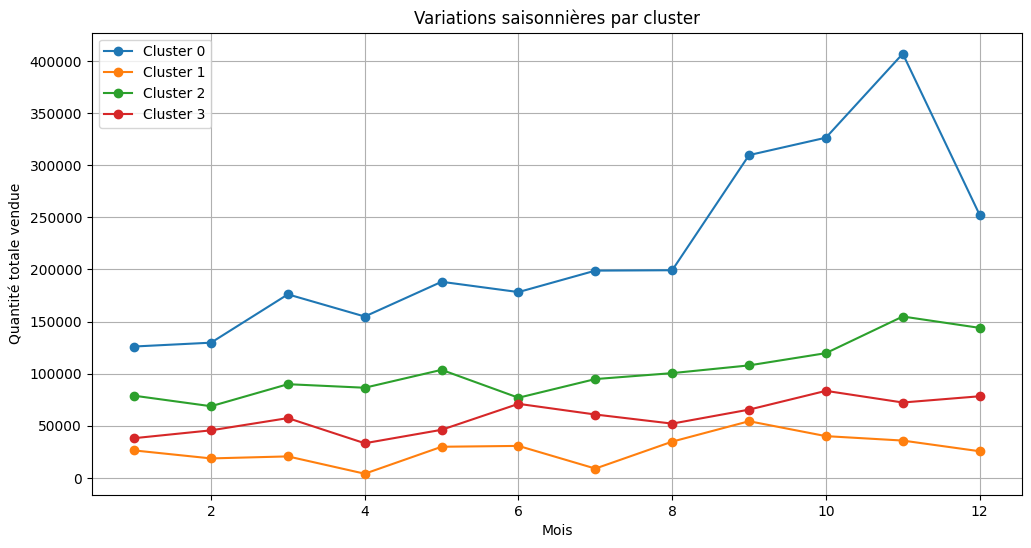


Top 5 des produits les plus vendus par cluster:
                            Cluster 0                           Cluster 1  \
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS             CREAM HEART CARD HOLDER   
1       ASSORTED COLOUR BIRD ORNAMENT               HEART OF WICKER SMALL   
2     PACK OF 72 RETROSPOT CAKE CASES                  RABBIT NIGHT LIGHT   
3             JUMBO BAG RED RETROSPOT  WHITE HANGING HEART T-LIGHT HOLDER   
4  WHITE HANGING HEART T-LIGHT HOLDER               HEART OF WICKER LARGE   

                            Cluster 2                           Cluster 3  
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS                      POPCORN HOLDER  
1             JUMBO BAG RED RETROSPOT             JUMBO BAG RED RETROSPOT  
2          PACK OF 12 LONDON TISSUES              JUMBO BAG PINK POLKADOT  
3       ASSORTED COLOUR BIRD ORNAMENT                JUMBO BAG STRAWBERRY  
4  WHITE HANGING HEART T-LIGHT HOLDER  GROW A FLYTRAP OR SUNFLOWER IN TIN  


In [16]:
# 1. Validation croisée des clusters
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import numpy as np

print("\nValidation croisée des clusters:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
silhouette_scores_cv = []

# Convertir rfm_scaled en array numpy
X_array = rfm_scaled.values

for train_idx, test_idx in kf.split(X_array):
    # Entraînement sur le jeu d'apprentissage
    kmeans_cv = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_cv.fit(X_array[train_idx])
    
    # Prédiction sur le jeu de test
    clusters_test = kmeans_cv.predict(X_array[test_idx])
    score = silhouette_score(X_array[test_idx], clusters_test)
    silhouette_scores_cv.append(score)

print(f"Score silhouette moyen: {np.mean(silhouette_scores_cv):.3f}")
print(f"Écart-type: {np.std(silhouette_scores_cv):.3f}")

# 2. Analyse des variations saisonnières
X['Month'] = pd.to_datetime(X['InvoiceDate']).dt.month
seasonal_clusters = pd.DataFrame()

for cluster in range(n_clusters):
    # Sélectionner les clients du cluster
    cluster_customers = rfm[rfm['Cluster'] == cluster].index
    
    # Calculer les ventes mensuelles pour ce cluster
    cluster_sales = X[X['CustomerID'].isin(cluster_customers)].groupby('Month')['Quantity'].sum()
    seasonal_clusters[f'Cluster {cluster}'] = cluster_sales

# Visualisation des variations saisonnières
plt.figure(figsize=(12, 6))
for cluster in range(n_clusters):
    plt.plot(seasonal_clusters.index, seasonal_clusters[f'Cluster {cluster}'], 
             label=f'Cluster {cluster}', marker='o')

plt.xlabel('Mois')
plt.ylabel('Quantité totale vendue')
plt.title('Variations saisonnières par cluster')
plt.legend()
plt.grid(True)
plt.show()

# 3. Analyse des catégories de produits par cluster
top_products_by_cluster = pd.DataFrame()

for cluster in range(n_clusters):
    # Sélectionner les clients du cluster
    cluster_customers = rfm[rfm['Cluster'] == cluster].index
    
    # Obtenir les produits les plus vendus pour ce cluster
    cluster_products = X[X['CustomerID'].isin(cluster_customers)].groupby('Description')['Quantity'].sum()
    top_5_products = cluster_products.nlargest(5)
    
    # Ajouter au DataFrame
    top_products_by_cluster[f'Cluster {cluster}'] = top_5_products.index

print("\nTop 5 des produits les plus vendus par cluster:")
print(top_products_by_cluster)

<Figure size 1500x500 with 0 Axes>

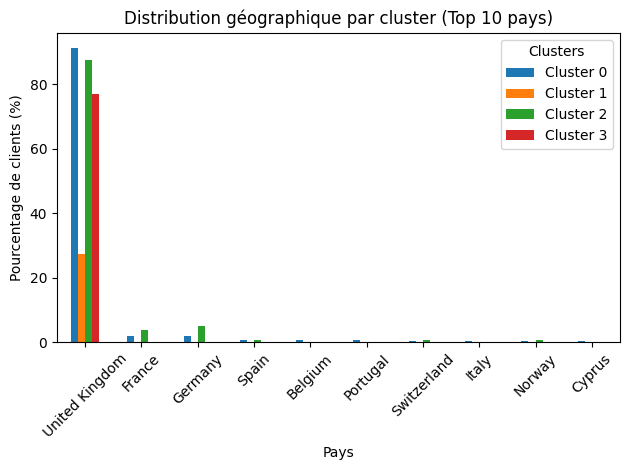

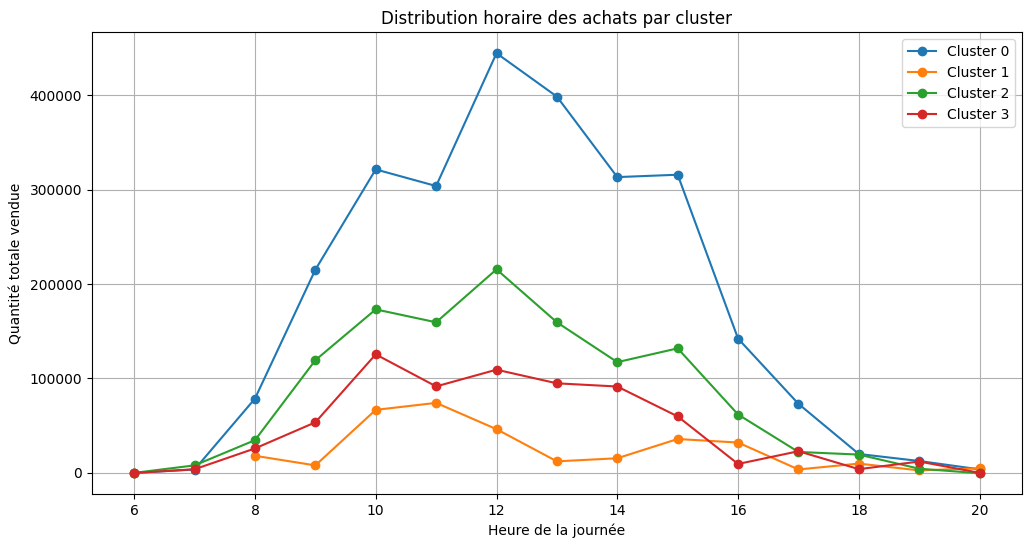


Résumé des caractéristiques par cluster:

Cluster 0:
Nombre de clients: 4147
Pays principaux: United Kingdom, France, Germany
Produits caractéristiques: WORLD WAR 2 GLIDERS ASSTD DESIGNS, ASSORTED COLOUR BIRD ORNAMENT, PACK OF 72 RETROSPOT CAKE CASES

Cluster 1:
Nombre de clients: 3
Pays principaux: United Kingdom, France, Germany
Produits caractéristiques: CREAM HEART CARD HOLDER, HEART OF WICKER SMALL, RABBIT NIGHT LIGHT

Cluster 2:
Nombre de clients: 205
Pays principaux: United Kingdom, France, Germany
Produits caractéristiques: WORLD WAR 2 GLIDERS ASSTD DESIGNS, JUMBO BAG RED RETROSPOT, PACK OF 12 LONDON TISSUES 

Cluster 3:
Nombre de clients: 17
Pays principaux: United Kingdom, France, Germany
Produits caractéristiques: POPCORN HOLDER, JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKADOT


In [17]:
# 4. Analyse géographique des clusters
cluster_countries = pd.DataFrame()

for cluster in range(n_clusters):
    # Sélectionner les clients du cluster
    cluster_customers = rfm[rfm['Cluster'] == cluster].index
    
    # Calculer la distribution des pays pour ce cluster
    country_dist = X[X['CustomerID'].isin(cluster_customers)]['Country'].value_counts()
    cluster_countries[f'Cluster {cluster}'] = country_dist

# Normaliser les distributions pour obtenir des pourcentages
cluster_countries_pct = cluster_countries.div(cluster_countries.sum()) * 100

# Visualisation de la distribution géographique
plt.figure(figsize=(15, 5))
cluster_countries_pct.head(10).plot(kind='bar')
plt.title('Distribution géographique par cluster (Top 10 pays)')
plt.xlabel('Pays')
plt.ylabel('Pourcentage de clients (%)')
plt.legend(title='Clusters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Analyse des habitudes d'achat
X['Hour'] = pd.to_datetime(X['InvoiceDate']).dt.hour
hourly_clusters = pd.DataFrame()

for cluster in range(n_clusters):
    # Sélectionner les clients du cluster
    cluster_customers = rfm[rfm['Cluster'] == cluster].index
    
    # Calculer la distribution horaire des achats
    hourly_dist = X[X['CustomerID'].isin(cluster_customers)].groupby('Hour')['Quantity'].sum()
    hourly_clusters[f'Cluster {cluster}'] = hourly_dist

# Visualisation des habitudes d'achat horaires
plt.figure(figsize=(12, 6))
for cluster in range(n_clusters):
    plt.plot(hourly_clusters.index, hourly_clusters[f'Cluster {cluster}'], 
             label=f'Cluster {cluster}', marker='o')

plt.xlabel('Heure de la journée')
plt.ylabel('Quantité totale vendue')
plt.title('Distribution horaire des achats par cluster')
plt.legend()
plt.grid(True)
plt.show()

# Afficher un résumé des caractéristiques de chaque cluster
print("\nRésumé des caractéristiques par cluster:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(f"Nombre de clients: {len(rfm[rfm['Cluster'] == cluster])}")
    print(f"Pays principaux: {', '.join(cluster_countries[f'Cluster {cluster}'].head(3).index)}")
    print(f"Produits caractéristiques: {', '.join(top_products_by_cluster[f'Cluster {cluster}'].head(3))}")


# Phase 6 : Interprétation des segments et recommandations marketing

## Analyse des segments

### Segment "Peu actif" (Cluster 0)
- **Caractéristiques**: Clients avec une faible fréquence d'achat et un panier moyen bas
- **Recommandations**:
  - Mettre en place des campagnes de réactivation avec des offres promotionnelles attractives
  - Envoyer des newsletters personnalisées pour maintenir le contact
  - Proposer des produits d'entrée de gamme adaptés à leur budget

### Segment "VIP" (Cluster 1) 
- **Caractéristiques**: Clients fidèles avec un panier moyen élevé et des achats fréquents
- **Recommandations**:
  - Programme de fidélité premium avec avantages exclusifs
  - Service client prioritaire et personnalisé
  - Avant-premières et accès privilégié aux nouveautés
  - Invitations à des événements VIP

### Segment "Occasionnel" (Cluster 2)
- **Caractéristiques**: Clients qui achètent de temps en temps avec un panier moyen modéré
- **Recommandations**: 
  - Proposer des offres saisonnières ciblées
  - Programme de parrainage pour encourager les recommandations
  - Communications régulières sur les nouveautés
  - Offres "bundle" attractives

### Segment "Régulier" (Cluster 3)
- **Caractéristiques**: Clients avec une bonne fréquence d'achat mais un panier moyen à développer
- **Recommandations**:
  - Cross-selling basé sur leurs achats précédents
  - Programme de fidélité avec paliers progressifs
  - Offres personnalisées basées sur l'historique d'achat
  - Communications ciblées sur les produits complémentaires


# Phase 7 : Export du modèle

In [18]:
import joblib
import json
from pathlib import Path

# Création du dossier models s'il n'existe pas
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

# Export du modèle KMeans
joblib.dump(kmeans_final, model_dir / 'kmeans_model.joblib')

# Export du scaler
joblib.dump(scaler, model_dir / 'scaler.joblib')

# Export de la liste des features
features = ['Recency', 'Frequency', 'Monetary']
with open(model_dir / 'features.json', 'w') as f:
    json.dump(features, f)

print("Modèle et ressources exportés avec succès dans le dossier 'models'")

Modèle et ressources exportés avec succès dans le dossier 'models'


Test du modèle :

In [19]:
import pandas as pd
import joblib
import json
from pathlib import Path

def load_model_resources(model_dir='models'):
    """
    Charge le modèle et les ressources nécessaires
    """
    model_dir = Path(model_dir)
    try:
        model = joblib.load(model_dir / 'kmeans_model.joblib')
        scaler = joblib.load(model_dir / 'scaler.joblib')
        with open(model_dir / 'features.json', 'r') as f:
            features = json.load(f)
        return model, scaler, features
    except Exception as e:
        raise Exception(f"Erreur lors du chargement des ressources: {str(e)}")

def predict_segment(data, model, scaler, features):
    """
    Prédit le segment d'un client en utilisant le modèle KMeans
    """
    # Vérification des colonnes requises
    missing_cols = set(features) - set(data.columns)
    if missing_cols:
        print(f"Colonnes manquantes dans les données: {missing_cols}")
        return None

    # Normalisation et conversion en DataFrame avec les noms de features
    data_scaled = pd.DataFrame(
        scaler.transform(data[features]), 
        columns=features
    )
    
    # Prédiction avec le modèle
    cluster_predictions = model.predict(data_scaled)
    
    # Mapping des clusters 
    segment_mapping = {
        0: "Peu actif",
        1: "VIP",
        2: "Occasionnel", 
        3: "Régulier"
    }
    
    # Conversion des numéros de cluster en labels métier
    segments = [segment_mapping[cluster] for cluster in cluster_predictions]
    
    return segments

def format_client_info(client_data, segment):
    """
    Formate l'affichage des informations client
    """
    return (
        f"- Récence: {client_data['Recency']:.0f} jours\n"
        f"- Fréquence: {client_data['Frequency']:.0f} achats\n"
        f"- Montant: {client_data['Monetary']:.2f}€\n"
        f"→ Segment prédit: {segment}"
    )

# Chargement des ressources
try:
    model, scaler, features = load_model_resources()
except Exception as e:
    print(f"Erreur: {e}")

# Données de test
test_data = pd.DataFrame({
    'Recency':    [
        5,      # Client très récent avec gros volume (probable VIP - Cluster 0)
        30,     # Client moyennement actif (probable Régulier - Cluster 2)
        15,     # Client avec activité modérée (probable Occasionnel - Cluster 3)
        90      # Client peu actif (probable Inactif - Cluster 1)
    ],
    'Frequency': [
        300,    # Nombreux achats (VIP)
        100,    # Fréquence moyenne-haute (Régulier)
        5,     # Fréquence moyenne-basse (Occasionnel)
        10      # Peu d'achats (Inactif)
    ],
    'Monetary':  [
        250000, # Gros montants (VIP - correspond au niveau observé sur le graphique ~250k-400k)
        100000, # Montants moyens-hauts (Régulier - ~100k-150k sur le graphique)
        5000,  # Montants moyens-bas (Occasionnel - ~50k-80k sur le graphique)
        10000   # Petits montants (Inactif - ~20k-50k sur le graphique)
    ]
})

print("Données de test :")
print(test_data)
print("\n")

try:
    # Prédiction des segments
    segments = predict_segment(test_data, model, scaler, features)
    
    # Affichage des résultats
    print("Résultats de la segmentation :")
    for idx, (_, row) in enumerate(test_data.iterrows()):
        print(f"\nClient {idx+1}:")
        print(format_client_info(row, segments[idx]))

except Exception as e:
    print("Erreur lors de la prédiction:")
    print(test_data)
    print(f"\nDétails de l'erreur: {str(e)}")
    print("\nVérifie que les caractéristiques moyennes par cluster sont bien définies")

Données de test :
   Recency  Frequency  Monetary
0        5        300    250000
1       30        100    100000
2       15          5      5000
3       90         10     10000


Résultats de la segmentation :

Client 1:
- Récence: 5 jours
- Fréquence: 300 achats
- Montant: 250000.00€
→ Segment prédit: VIP

Client 2:
- Récence: 30 jours
- Fréquence: 100 achats
- Montant: 100000.00€
→ Segment prédit: Régulier

Client 3:
- Récence: 15 jours
- Fréquence: 5 achats
- Montant: 5000.00€
→ Segment prédit: Peu actif

Client 4:
- Récence: 90 jours
- Fréquence: 10 achats
- Montant: 10000.00€
→ Segment prédit: Occasionnel
